<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=8>
Introduction to Machine Learning <br>
<font color=696880 size=5>
<!-- <br> -->
Computer Engineering Department
<br>
Sharif University of Technology

<font color=696880 size=5>
<br>
CE 40477 - Fall 2024

<font color=GREEN size=5>
<br>
Mahan Bayhaghi & Mahdi Akbar
<!-- <br> -->

____



# Logistic Regression

## Binary Classification
In this section, we will use [breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) of scikit-learn which is a classic binary classification dataset used for machine learning. This dataset contains multiple features for tumors as well as it's label (either benign or malignant).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

data = load_breast_cancer()
X = data.data
y = data.target  # labels (0: malignant, 1: benign)
print(data.feature_names)


['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


For the sake of visualization, we will only use two features: mean perimeter of tumor and mean smoothness of it.

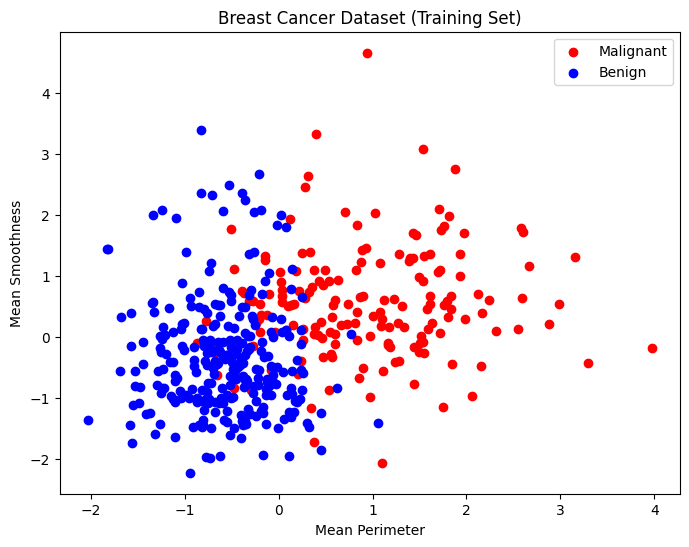

In [6]:
# we will only take two features for visualization purposes
X = data.data[:, [0, 1]]  # mean perimeter and mean smoothnes
#NumPy array from sklearn.datasets.load_breast_cancer()
#picks columns 2 and 4 only

# Standardizing the features
scaler = StandardScaler()
#subtract mean, divide by std deviation (to make features comparable)
X = scaler.fit_transform(X)

# add bias (x_0 = 1) term to X
#np.ones((X.shape[0], 1)) creates a column of ones.
#np.hstack(...) horizontally stacks it to the data.
#New shape is now (samples, 3):
#[feature1, feature2, 1]
X_bias = np.hstack((X, np.ones((X.shape[0], 1))))

#X_train and X_val: training and validation features
#y_train and y_val: corresponding labels
#test_size=0.2: 20% for validation,random_state=42: For reproducibility,
#stratify=y: Keeps the same ratio of malignant/benign in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X_bias, y, test_size=0.2, random_state=42, stratify=y
)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Malignant')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Benign')
plt.xlabel('Mean Perimeter')
plt.ylabel('Mean Smoothness')
plt.title('Breast Cancer Dataset (Training Set)')
plt.legend()
plt.show()

First, let us define $ \sigma(z) $ and function for loss and gradient descent:

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(w, X, y):
    # matrix multiplication of inputs and weights
    z = X @ w
    # applying the sigmoid function to get predicted probabilities
    predictions = sigmoid(z)
    # binary cross-entropy loss
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

def compute_gradient(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    # error = difference between predicted and true labels
    errors = predictions - y
    # compute the gradient of the loss function
    gradient = X.T @ errors / len(y)
    return gradient

def validation_accuracy(w, X_val, y_val):
    # Compute predicted probabilities on the validation set
    probabilities = sigmoid(X_val @ w)
    # Apply a threshold to convert probabilities into binary predictions (0 or 1)
    # If probability > 0.5, predict class 1; else predict class 0
    predictions = (probabilities > 0.5).astype(int) # decission rule for binary classification
    # Compare predictions to true labels to calculate accuracy
    accuracy = np.mean(predictions == y_val)
    return accuracy

In [11]:
def gradient_descent_logistic(X_train, y_train, X_val, y_val,
                              learning_rate=0.1, n_steps=1000, tolerance=1e-6):
    # Initialize weights as zeros (one for each feature including bias)
    w = np.zeros(X_train.shape[1])

    # Store the initial loss value before any updates
    loss_history = [compute_loss(w, X_train, y_train)]

    # Store initial validation accuracy
    val_accuracy_history = [validation_accuracy(w, X_val, y_val)]

    # Save the initial weights (used later for visualizing decision boundary changes)
    weights_history = [w.copy()]

    # Start gradient descent loop
    for step in range(1, n_steps + 1):
        # Compute gradient of the loss w.r.t. weights
        grad = compute_gradient(w, X_train, y_train)

        # Update weights in the opposite direction of the gradient
        w -= learning_rate * grad

        # Compute the new loss after the update
        loss = compute_loss(w, X_train, y_train)
        loss_history.append(loss)

        # Compute accuracy on the validation set
        acc = validation_accuracy(w, X_val, y_val)
        val_accuracy_history.append(acc)

        # Save weights every 10 steps (for plotting the decision boundary over time)
        if step % 10 == 0:
            weights_history.append(w.copy())

        # Check if the loss improvement is smaller than the threshold (convergence)
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

        # Every 100 steps, print progress
        if step % 100 == 0:
            print(f'Step {step}: Loss = {loss:.4f}, Validation Accuracy = {acc:.4f}')

    # Return final weights, full loss history, accuracy history, and saved weights
    return w, loss_history, val_accuracy_history, weights_history


The only thing remaining is to train our model on whole dataset:

In [12]:
learning_rate = 0.05
n_steps = 800

w_opt, loss_history, val_accuracy_history, weights_history = gradient_descent_logistic(
    X_train, y_train, X_val, y_val,
    learning_rate=learning_rate,
    n_steps=n_steps,
)

print(f'Optimized weights: {w_opt}')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} > 0 : Benign')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} < 0 : Malignant')

Step 100: Loss = 0.3767, Validation Accuracy = 0.9035
Step 200: Loss = 0.3203, Validation Accuracy = 0.9035
Step 300: Loss = 0.2974, Validation Accuracy = 0.8947
Step 400: Loss = 0.2850, Validation Accuracy = 0.8860
Step 500: Loss = 0.2774, Validation Accuracy = 0.8860
Step 600: Loss = 0.2723, Validation Accuracy = 0.8772
Step 700: Loss = 0.2687, Validation Accuracy = 0.8772
Step 800: Loss = 0.2661, Validation Accuracy = 0.8772
Optimized weights: [-2.69441061 -0.76266434  0.61450262]
Decision rule: -2.6944106143870674 * Mean Perimeter + -0.7626643387998138 * Mean Smoothness + 0.6145026219593516 > 0 : Benign
Decision rule: -2.6944106143870674 * Mean Perimeter + -0.7626643387998138 * Mean Smoothness + 0.6145026219593516 < 0 : Malignant


Let's visualize the change of decision boundary:

In [14]:
def plot_decision_boundary(w, X, y, step, total_steps):
    # Create two x-values spanning the width of the plot
    x_values = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])

    if w[1] != 0:
        # Compute corresponding y-values for the decision boundary line using: w0*x + w1*y + w2 = 0
        # Solving for y: y = -(w0*x + w2) / w1
        y_values = -(w[0] * x_values + w[2]) / w[1]

        # Plot the decision boundary line in green
        # alpha controls transparency — later steps are more visible (darker)
        plt.plot(x_values, y_values, color='green', alpha=(0.20 + (step / total_steps) * 0.20))
    else:
        # Special case: vertical decision boundary when w1 = 0
        plt.axvline(x=-w[2] / w[0], color='green')

    plt.legend()


def plot_decision_boundaries(weights_history, X, y, total_steps):
    plt.figure(figsize=(8, 6))

    # Plot the two classes of training data
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Malignant')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Benign')

    # Set the visible range of the axes
    plt.xlim(-2.5, 3)
    plt.ylim(-3, 3)

    # Plot all saved decision boundaries from training (every 10 steps)
    for i, w in enumerate(weights_history):
        step = i * 10  # Convert index back to step number
        plot_decision_boundary(w, X, y, step, total_steps)

    # Final title and show plot
    plt.title('Decision Boundaries during Gradient Descent')
    plt.show()


The plot above shows that decision boundary is trying to classify data points better at each step. Let's visualize this behaviour on loss function as well as validation accuracy:

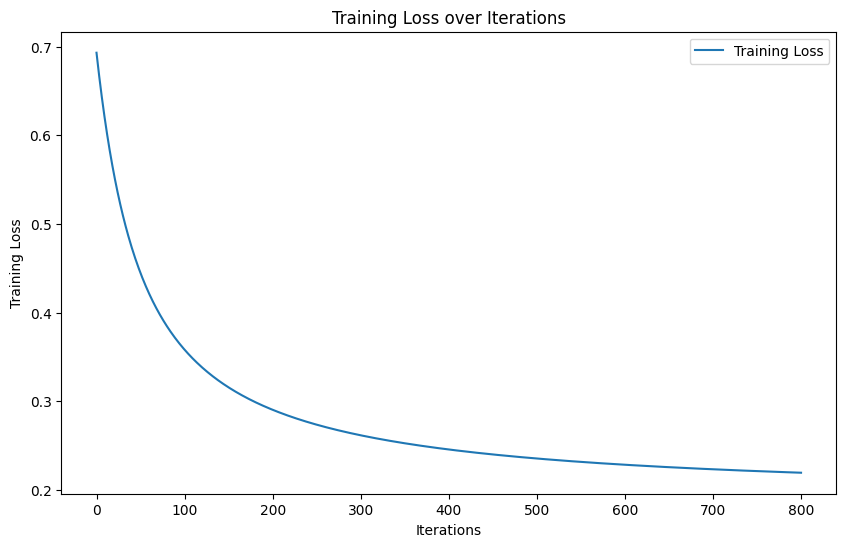

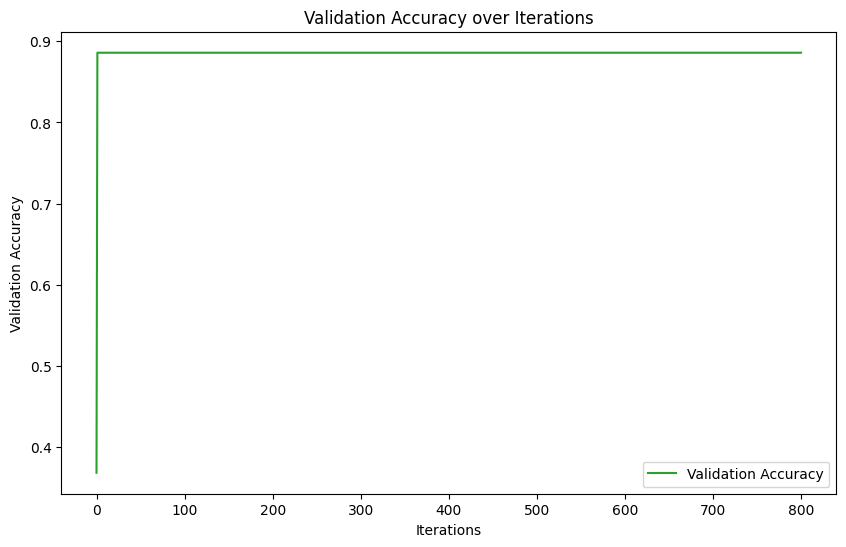

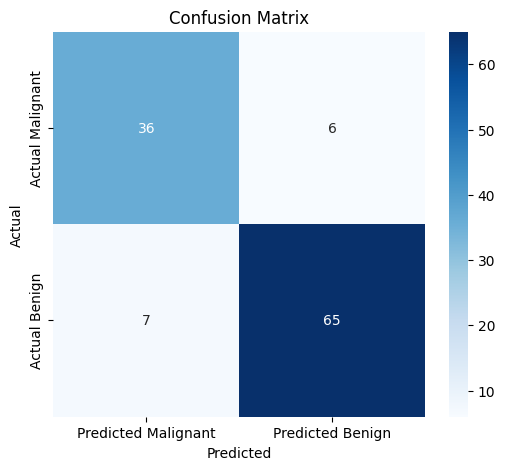

In [ ]:
def plot_training_loss(loss_history):
    epochs = range(len(loss_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_history, color='tab:blue', label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Iterations')
    plt.legend()
    plt.show()

def plot_validation_accuracy(val_accuracy_history):
    epochs = range(len(val_accuracy_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracy_history, color='tab:green', label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy over Iterations')
    plt.legend()
    plt.show()


def plot_confusion_matrix_cm(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    predictions = (probabilities > 0.5).astype(int)

    cm = confusion_matrix(y_val, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Malignant', 'Predicted Benign'],
                yticklabels=['Actual Malignant', 'Actual Benign'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_training_loss(loss_history)
plot_validation_accuracy(val_accuracy_history)
plot_confusion_matrix_cm(w_opt, X_val, y_val)


## Multi-class classification
So far, we have had implemented binary classification using binary cross entropy loss function. For the paradigm of multi-class problems, we will use softmax and update weights of each class accordingly.

For this section, we will use iris dataset of scikit learn.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target  # labels (0, 1, 2 for the three classes)

print("Feature Names:", data.feature_names)
print("Target Names:", data.target_names)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


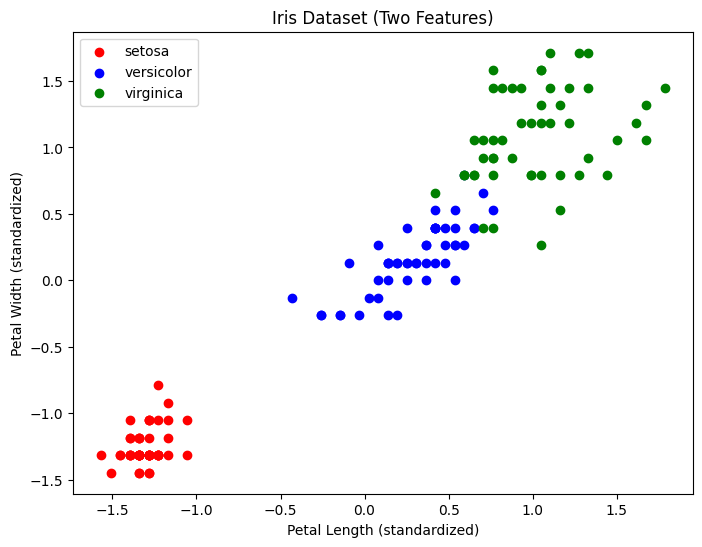

In [ ]:
# Select two features: petal length and petal width
feature_indices = [2, 3]  # 0-based indexing
X = X[:, feature_indices]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a bias term (column of ones) to the feature matrix
X_bias = np.hstack((X_scaled, np.ones((X_scaled.shape[0], 1))))

# Plot the standardized data
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
labels = data.target_names

for i in range(len(colors)):
    plt.scatter(X_scaled[y == i, 0], X_scaled[y == i, 1], color=colors[i], label=labels[i])

plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('Iris Dataset (Two Features)')
plt.legend()
plt.show()


Let us define softmax and GD as well:

In [ ]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(w, X, y):
    z = X @ w
    predictions = softmax(z)

    # converting labels to one-hot encoding
    y_onehot = np.zeros_like(predictions)
    y_onehot[np.arange(len(y)), y] = 1

    # cross-entropy loss
    epsilon = 1e-15  # to avoid log(0)
    loss = -np.mean(np.sum(y_onehot * np.log(predictions + epsilon), axis=1))
    return loss

def compute_gradient(w, X, y):
    z = X @ w
    predictions = softmax(z)

    # converting labels to one-hot encoding
    y_onehot = np.zeros_like(predictions)
    y_onehot[np.arange(len(y)), y] = 1

    # gradient itself
    errors = predictions - y_onehot
    gradient = X.T @ errors / len(y)
    return gradient

def gradient_descent_multiclass(X, y, learning_rate=0.1, n_steps=10000, tolerance=1e-6):
    n_features = X.shape[1]
    n_classes = np.max(y) + 1  # labels are 0-indexed

    w = np.zeros((n_features, n_classes)) # start with all weights equal to zero
    loss_history = [compute_loss(w, X, y)]
    weights_history = [w.copy()]  # For plotting decision boundaries

    for step in range(1, n_steps + 1):
        grad = compute_gradient(w, X, y)
        w -= learning_rate * grad
        loss = compute_loss(w, X, y)
        loss_history.append(loss)

        # storing weights every 10 steps for visualization
        if step % 10 == 0:
            weights_history.append(w.copy())

        # check for convergence
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

    return w, loss_history, weights_history

Converged at step 9646


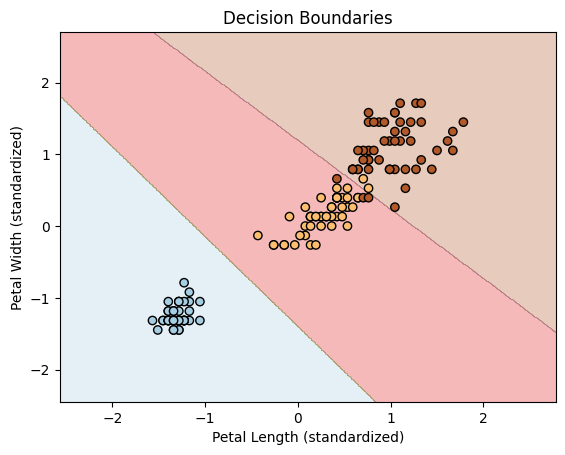

In [ ]:
w, loss_history, weights_history = gradient_descent_multiclass(X_bias, y)

# visualize decision boundaries
def plot_decision_boundaries(X, y, w):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    X_grid = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    Z = np.argmax(softmax(X_grid @ w), axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Petal Length (standardized)')
    plt.ylabel('Petal Width (standardized)')
    plt.title('Decision Boundaries')
    plt.show()

# decision boundaries
plot_decision_boundaries(X_scaled, y, w)


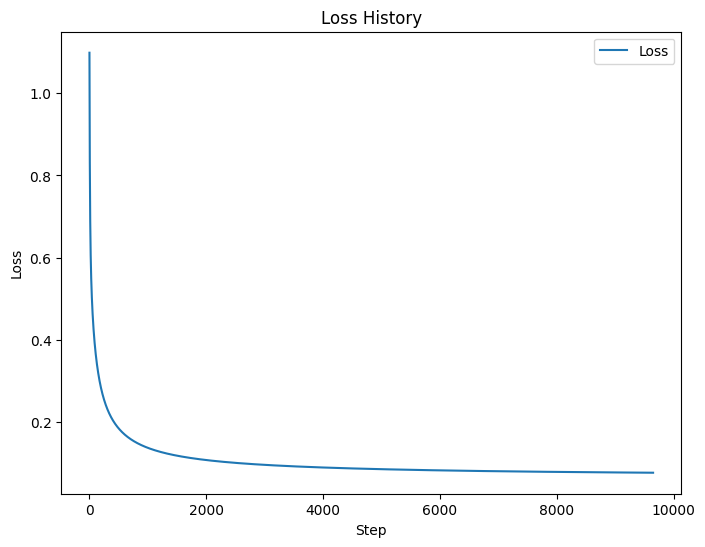

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()